In [59]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [61]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [62]:
# training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

In [63]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

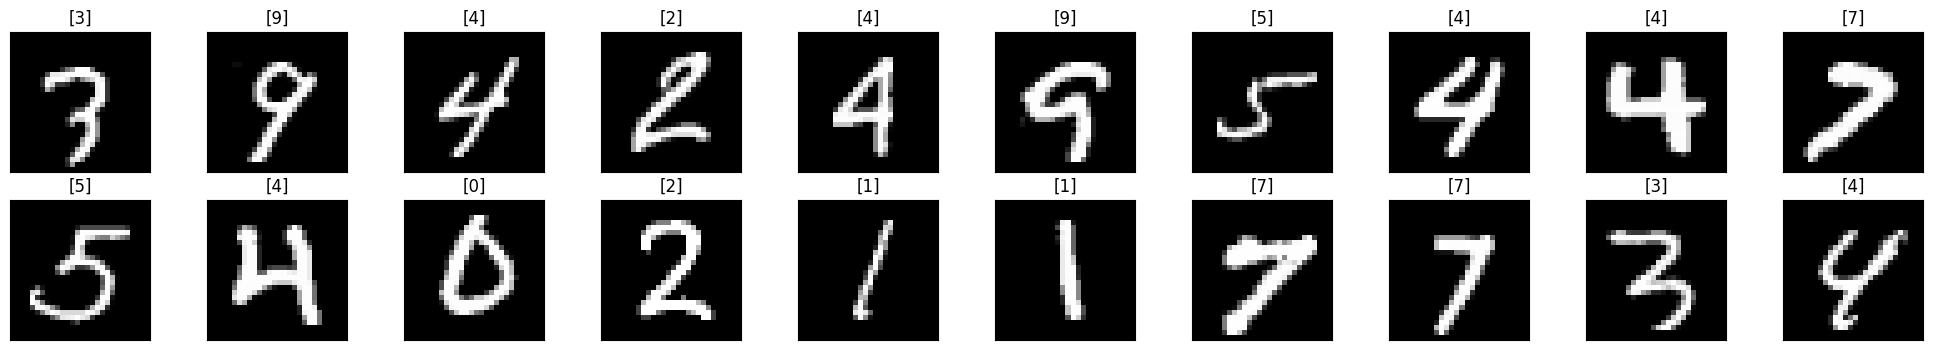

In [64]:
dataiter = iter(training_loader)
images, labels = next(dataiter)
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title([labels[idx].item()])

In [65]:
 class Classifier(nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        super().__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [66]:
model = Classifier(784, 125, 65, 10).to(device)
model

Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [67]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [68]:
epochs = 15
running_loss_history = []
running_corrects_history = []

test_running_loss_history = []
test_running_corrects_history = []

for e in range(epochs):

    running_loss = 0.0
    running_corrects = 0.0

    test_running_loss = 0.0
    test_running_corrects = 0.0

    for inputs, labels in training_loader:
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        inputs = inputs.view(inputs.shape[0], -1)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)

        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)


    else:
        with torch.no_grad():
            for test_inputs, test_labels in test_loader:
                
                test_inputs = inputs.to(device)
                test_labels = labels.to(device)
                
                test_inputs = test_inputs.view(test_inputs.shape[0], -1)
                test_outputs = model(test_inputs)
                test_loss = criterion(test_outputs, test_labels)

                _, test_preds = torch.max(test_outputs, 1)
                test_running_loss += test_loss.item()
                test_running_corrects += torch.sum(test_preds == test_labels.data)

        epoch_loss = running_loss / len(training_loader)
        epoch_accuracy = running_corrects.float() / len(training_loader)

        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_accuracy)
        # ==========================//test//======================
        test_epoch_loss = test_running_loss / len(test_loader)
        test_epoch_accuracy = test_running_corrects.float() / len(test_loader)

        test_running_loss_history.append(test_epoch_loss)
        test_running_corrects_history.append(test_epoch_accuracy)

        print(f'epoch {e + 1}')
        print('training loss:{:.4f}, accuracy {:.4f}'.format(epoch_loss, epoch_accuracy.item()))
        print('test loss:{:.4f}, test accuracy {:.4f}'.format(test_epoch_loss, test_epoch_accuracy.item()))

epoch 1
training loss:0.9392, accuracy 75.8450
test loss:0.5335, test accuracy 88.0000
epoch 2
training loss:0.3746, accuracy 89.5383
test loss:0.1911, test accuracy 95.0000
epoch 3
training loss:0.3071, accuracy 91.1950
test loss:0.3212, test accuracy 90.0000
epoch 4
training loss:0.2713, accuracy 92.1467
test loss:0.2713, test accuracy 90.0000
epoch 5
training loss:0.2445, accuracy 92.9400
test loss:0.1580, test accuracy 94.0000
epoch 6
training loss:0.2231, accuracy 93.5783
test loss:0.3009, test accuracy 92.0000
epoch 7
training loss:0.2056, accuracy 94.0717
test loss:0.1687, test accuracy 93.0000
epoch 8
training loss:0.1911, accuracy 94.4267
test loss:0.1404, test accuracy 97.0000
epoch 9
training loss:0.1782, accuracy 94.8517
test loss:0.0932, test accuracy 97.0000
epoch 10
training loss:0.1672, accuracy 95.1517
test loss:0.0988, test accuracy 98.0000
epoch 11
training loss:0.1574, accuracy 95.3533
test loss:0.0832, test accuracy 97.0000
epoch 12
training loss:0.1479, accuracy 9

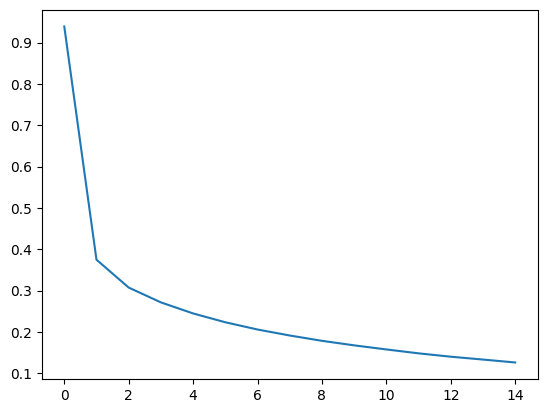

In [75]:
plt.plot(running_loss_history, label='training loss')

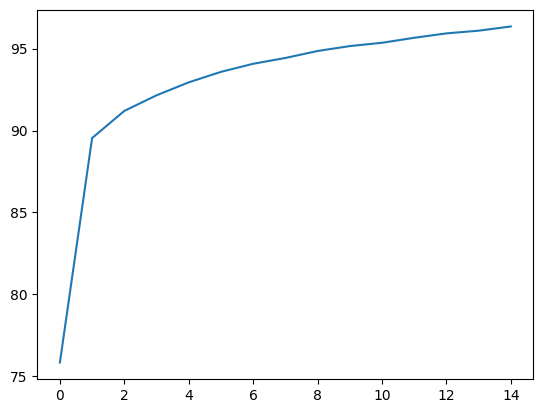

In [78]:
# Assuming running_corrects_history is a list of PyTorch tensors
# Convert and move tensors to CPU and then convert to NumPy arrays
running_corrects_history_numpy = [tensor.cpu().numpy() for tensor in running_corrects_history]

plt.plot(running_corrects_history_numpy, label='accuracy')
